# Лабораторная работа № 5.1

### Задача:

Используя явную и неявную конечно-разностные схемы, а также схему Кранка -
Николсона, решить начально-краевую задачу для дифференциального уравнения
параболического типа. Осуществить реализацию трех вариантов аппроксимации
граничных условий, содержащих производные: двухточечная аппроксимация с
первым порядком, трехточечная аппроксимация со вторым порядком, двухточечная
аппроксимация со вторым порядком. В различные моменты времени вычислить
погрешность численного решения путем сравнения результатов с приведенным в
задании аналитическим решением
$U(x,t)$
. Исследовать зависимость погрешности от
сеточных параметров
$\tau, h$ .

In [1]:
import math, numpy as np, pandas as pd
import warnings
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from matplotlib import cm
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Условие

$$ \frac{\partial u}{\partial t} = a \frac{\partial^2 u}{\partial x^2} + b \frac{\partial u}{\partial x} + cu, a>0, b>0, c<0. $$

$$ u_x(0, t) + u(0, t) = e^{(c-a)t}(cos(bt) + sin(bt)) $$
$$ u_x(\pi, t) + u(\pi, t) = -e^{(c-a)t}(cos(bt) + sin(bt)) $$
$$ u(x, 0) = sin(x) $$

### Аналитическое решение


$$ U(x,t) = e^{(c - a)t}sin(x + bt) $$

### Численные методы

In [2]:
# Коэффициенты уравнения
a, b, c = 1, 2, -5
# Длина и время
l = np.pi
T = 3.0
# Параметры численного решения
sigma = 1/2
n = 20

alpha0, betta0, alphal, bettal = 1, 1, 1, 1

def f(x, t):
    return 0

def psi(x):
    return np.sin(x)

def phi0(t):
    return np.exp((c-a)*t)*(np.cos(b*t) + np.sin(b*t))

def phil(t):
    return -np.exp((c-a)*t)*(np.cos(b*t) + np.sin(b*t))

def decision(x, t):
    return np.exp((c-a) * t) * np.sin(x + b*t)

In [3]:
# a, b, c = 0.4, 2, 0

# l = np.pi
# T = 2

# sigma = 1/4
# n = 80

# alpha0, betta0, alphal, bettal = 1, -1, 1, -1

# def f(x, t):
#     return 0

# def psi(x):
#     return np.cos(x)

# def phi0(t):
#     return -np.exp(-a*t)*(np.cos(b*t) + np.sin(b*t))

# def phil(t):
#     return np.exp(-a*t)*(np.cos(b*t) + np.sin(b*t))

# def decision(x, t):
#     return np.exp(-a * t) * np.cos(x + b*t)

Утилиты

In [4]:
class Scheme:
    def __init__(self, a, b, c, l, T, sigma, n, f, psi, phi0, phil, alpha0, betta0, alphal, bettal):
        
        self.a, self.b, self.c, self.l, self.T, self.sigma, self.n, self.f, self.psi, self.phi0, self.phil, \
        self.alpha0, self.betta0, self.alphal, self.bettal = a, b, c, l, T, sigma, n, f, psi, phi0, phil, \
        alpha0, betta0, alphal, bettal
        
        self.h = l / n
        self.tau = (sigma * self.h**2) / a
        self.k = int(T / self.tau)
        self.result = [[0 for j in range(self.k + 1)] for i in range(self.n + 1)]
        
        print(self.n, self.k)
        
    def x_i(self, i):
        return self.h * i
    
    def t_k(self, k):
        return self.tau * k
    
    def _TMA(self, abc, d):
        if len(d) == 1:
            return [d[0] / abc[1][0]]
        dimension = len(d);
        result = [0 for i in range(dimension)]

        P = [0 for i in range(dimension)]
        Q = [0 for i in range(dimension)]
        P[0] = -(abc[2][0] / abc[1][0])
        Q[0] = (d[0] / abc[1][0])

        for i in range(1, dimension - 1):
            P[i] = -(abc[2][i] / (abc[1][i] + abc[0][i - 1] * P[i - 1]))
            Q[i] = ((d[i] - abc[0][i - 1] * Q[i - 1]) / (abc[1][i] + abc[0][i - 1] * P[i - 1]))


        result[dimension - 1] = ((d[dimension - 1] - abc[0][dimension - 2] * Q[dimension - 2])\
                                 / (abc[1][dimension - 1] + abc[0][dimension - 2] * P[dimension - 2]))

        for i in range(dimension - 1):
            k = dimension - 2 - i
            result[k] = P[k] * result[k + 1] + Q[k]

        return result
        
    def draw(self, rows):
        res = np.array(self.result).T.tolist()
        colums = 3
        all_count = colums * rows
        step = self.k // (all_count - 1)

        fig, ax = plt.subplots(rows, colums, figsize=(16, 4*rows), sharex='all', sharey='none')
        X = np.array([self.h*i for i in range(self.n+1)])

        for kk in range(0, all_count):

            TIME = np.array([self.tau*kk*step for i in range(self.n+1)])

            ax[kk // colums, kk % colums].plot(X, res[kk*step], '.-', X, decision(X, TIME))
            ax[kk // colums, kk % colums].set_title(f"{kk*step} (t = {self.tau*kk*step})")

        plt.show()
        
    def draw3D(self, vmax = None):
        XX = np.array([self.x_i(i) for i in range(self.n + 1)])
        TT = np.array([self.t_k(j) for j in range(self.k + 1)])
        XX, TT = np.meshgrid(XX, TT)
        ZZ = decision(XX, TT)
        
        fig = plt.figure(figsize=(16,8))
        ax1 = fig.add_subplot(2, 4, 1, projection = "3d")
        ax2 = fig.add_subplot(2, 4, 2, projection = "3d")
        ax3 = fig.add_subplot(2, 4, (3,4))
        
        ax1.plot_surface(XX, TT, ZZ, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        ax1.view_init(40, +30)
        
        ax2.plot_surface(XX, TT, np.array(self.result).T, cmap='viridis', linewidth=0, antialiased=False)
        ax2.view_init(40, +30)
        
        cf = ax3.contourf(XX, TT, np.abs(ZZ - np.array(self.result).T), 200, cmap=cm.coolwarm, vmax = vmax)
        fig.colorbar(cf)
        
        plt.show()
        
    def delta(self):
        res = np.array(self.result).T.tolist()
        time, delt = [], []

        _, _ = plt.subplots(1, 1, figsize=(16, 4))

        X = np.array([self.h*_i for _i in range(self.n+1)])

        for i in range(self.k):
            TIME = np.array([self.tau*i for _i in range(self.n+1)])
            aaa = np.abs(res[i] - decision(X, TIME))

            time.append(self.tau*i)
            delt.append(np.max(aaa))

        plt.plot(time, delt)
        plt.show()

#### Явная схема

In [5]:
class ExplicitScheme(Scheme):
    
    def __init__(self, a, b, c, l, T, sigma, n, f, psi, phi0, phil, alpha0, betta0, alphal, bettal):
        super().__init__(a, b, c, l, T, sigma, n, f, psi, phi0, phil, alpha0, betta0, alphal, bettal)
    
    def solve(self, app_mode = 1):
        
        for i in range(self.n + 1):
            self.result[i][0] = self.psi(self.x_i(i))

        aa = (self.a * self.tau / (self.h**2)) - (self.b * self.tau / (2 * self.h))
        bb = (-2*self.a*self.tau / (self.h**2)) + self.c * self.tau + 1
        gg = (self.a * self.tau / (self.h**2)) + (self.b * self.tau / (2 * self.h))

        for j in range(1, self.k + 1):
            for i in range(1, self.n):
                self.result[i][j] = aa * self.result[i-1][j-1] + bb * self.result[i][j-1] \
                                    + gg * self.result[i+1][j-1] + self.tau * self.f(self.x_i(i), self.t_k(j-1))

            if app_mode == 1:
                self.result[0][j] = (self.phi0(self.t_k(j)) - (self.alpha0 / self.h) * self.result[1][j]) \
                                    / (-self.alpha0 / self.h + self.betta0)

                self.result[self.n][j] = (self.phil(self.t_k(j)) + (self.alphal / self.h) * self.result[self.n-1][j]) \
                                / (self.alphal / self.h + self.bettal)
            elif app_mode == 2:
                self.result[0][j] = (self.phi0(self.t_k(j)) - (2 * self.alpha0 / self.h) * self.result[1][j] \
                                + (self.alpha0 / (2*self.h)) * self.result[2][j]) \
                                / (-3*self.alpha0 / (2*self.h) + self.betta0)

                self.result[self.n][j] = (self.phil(self.t_k(j)) + (2*self.alphal / self.h) * self.result[self.n-1][j] \
                                         - (self.alphal / (2*self.h)) * self.result[self.n-2][j]) \
                                    / (3*self.alphal / (2*self.h) + self.bettal)
            elif app_mode == 3:
                self.result[0][j] = (self.phi0(self.t_k(j)) * (self.h - ((self.h**2 * self.b)/(2*self.a))) \
                                    - (self.alpha0 * self.h**2 / (2*self.a*self.tau)) * self.result[0][j-1] \
                                    - self.alpha0 * self.result[1][j] \
                                    - (self.alpha0 * self.h**2 / (2*self.a)) * self.f(0, self.t_k(j))) \
                                    / (self.alpha0*(self.h**2 * self.c / (2*self.a) - self.h**2 / (2*self.a*self.tau) - 1) \
                                    + self.betta0 * (self.h - self.h**2 * self.b / (2 * self.a)))

                self.result[self.n][j] = (self.phil(self.t_k(j)) * (self.h + ((self.h**2 * self.b)/(2*self.a))) \
                                    + (self.alphal * self.h**2 / (2*self.a*self.tau)) * self.result[self.n][j-1] \
                                    + self.alphal * self.result[self.n-1][j] \
                                    + (self.alphal * self.h**2 / (2*self.a)) * self.f(self.l, self.t_k(j))) \
                                    / (self.alphal*(1 - self.h**2 * self.c / (2*self.a) + self.h**2 / (2*self.a*self.tau)) \
                                    + self.bettal * (self.h + self.h**2 * self.b / (2 * self.a)))
            
        return self.result

### 2Т1П

20 243


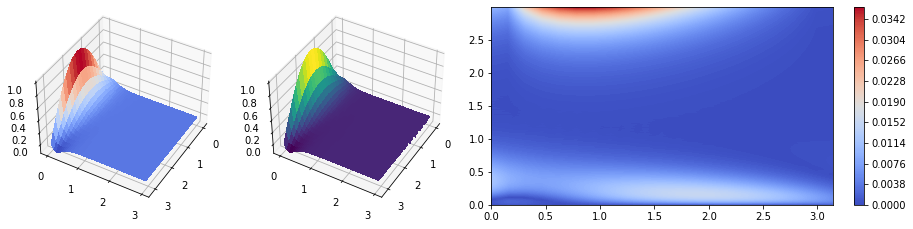

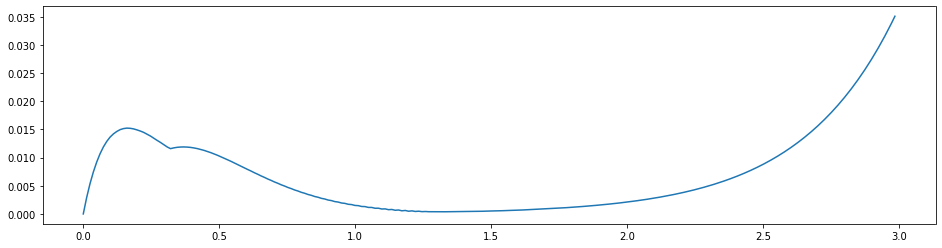

### 3Т2П

20 243


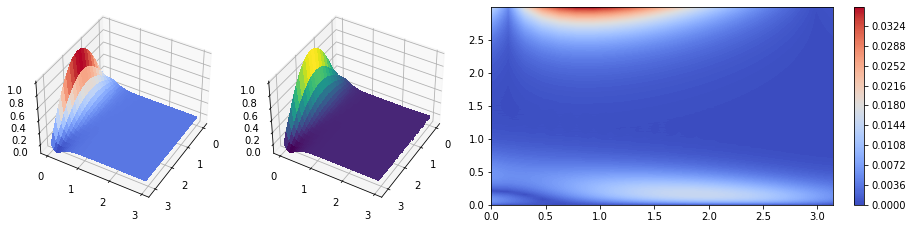

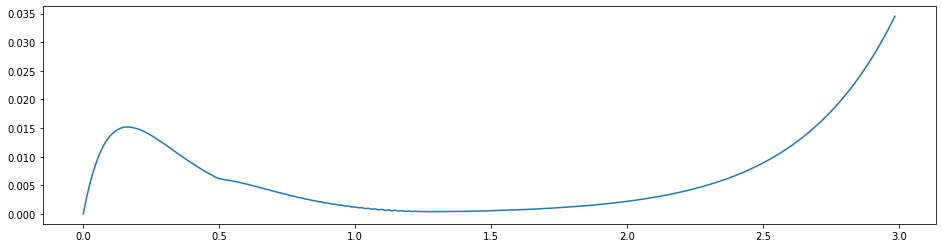

### 2Т2П

20 243


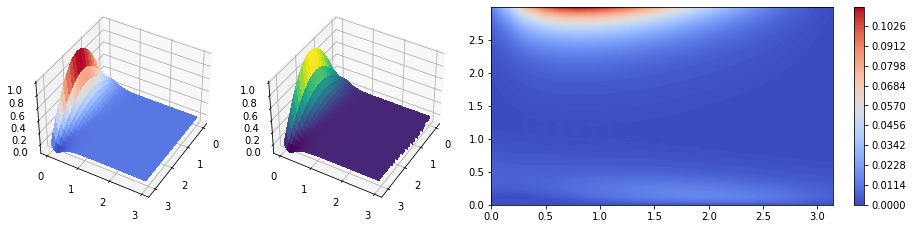

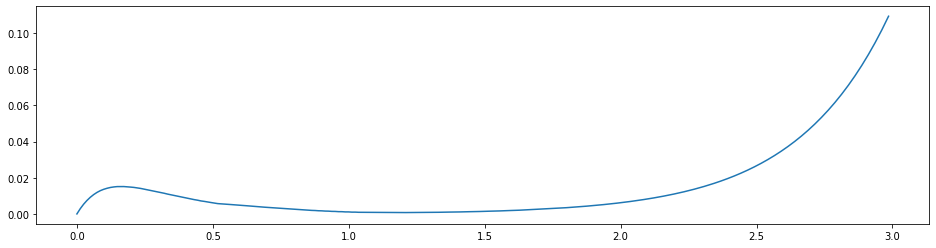

In [6]:
for i in [1,2,3]:
    display(Markdown(["### 2Т1П", "### 3Т2П", "### 2Т2П"][i-1]))
    ES = ExplicitScheme(a, b, c, l, T, sigma, n, f, psi, phi0, phil, alpha0, betta0, alphal, bettal)
    ES.solve(i)
    ES.draw3D()
    ES.delta()

#### Неявная схема

In [7]:
class ImplicitScheme(Scheme):
    
    def __init__(self, a, b, c, l, T, sigma, n, f, psi, phi0, phil, alpha0, betta0, alphal, bettal):
        super().__init__(a, b, c, l, T, sigma, n, f, psi, phi0, phil, alpha0, betta0, alphal, bettal)
    
    def solve(self, app_mode = 1):
        
        for i in range(self.n + 1):
            self.result[i][0] = self.psi(self.x_i(i))

        aa = (self.b * self.tau / (2 * self.h)) - (self.a * self.tau / (self.h**2))
        bb = 1 + (2*self.a*self.tau / (self.h**2)) - self.c * self.tau
        gg = - (self.a * self.tau / (self.h**2)) - (self.b * self.tau / (2 * self.h))
        x = self.alpha0 / (2 * self.h * gg)
        y = - self.alphal / (2 * self.h * aa)
        
        
        abc = [[0]*self.n, [0] * (self.n + 1), [0]*self.n]
        d = [0] * (self.n + 1)
        
        for j in range(1, self.k + 1):

            if app_mode == 1:
                for i in range(self.n + 1):
                    if i == 0:
                        d[i] = self.phi0(self.t_k(j))
                    elif i == n: 
                        d[i] = self.phil(self.t_k(j))
                    else: 
                        d[i] = self.result[i][j-1] + self.f(self.x_i(i), self.t_k(j)) * self.tau
                        
                    if i == 0:
                        abc[1][i] = self.betta0 - self.alpha0 / self.h
                        abc[2][i] = self.alpha0 / self.h
                    elif i == n:
                        abc[0][i-1] = - self.alphal / self.h
                        abc[1][i] = self.alphal / self.h + self.bettal
                    else:
                        abc[0][i-1] = aa
                        abc[1][i] = bb
                        abc[2][i] = gg
                        
                r = self._TMA(abc, d)
                
                for i in range(self.n + 1):
                    self.result[i][j] = r[i]
                    
            elif app_mode == 2:
                for i in range(self.n + 1):
                    if i == 0:
                        d[1] = self.result[1][j-1] + self.f(self.x_i(1), self.t_k(j)) * self.tau
                        d[i] = self.phi0(self.t_k(j)) + d[1] * x
                    elif i == n: 
                        d[i] = self.phil(self.t_k(j)) + d[n-1] * y
                    else: 
                        d[i] = self.result[i][j-1] + self.f(self.x_i(i), self.t_k(j)) * self.tau
                        
                    if i == 0:
                        abc[1][i] = self.betta0 - 3 * self.alpha0 / (2 * self.h) + aa * x
                        abc[2][i] = 2 * self.alpha0 / self.h + bb * x
                    elif i == n:
                        abc[0][i-1] = - 2 * self.alphal / self.h + bb * y
                        abc[1][i] = 3 * self.alphal / (2 * self.h) + self.bettal + gg * y
                    else:
                        abc[0][i-1] = aa
                        abc[1][i] = bb
                        abc[2][i] = gg
                        
                r = self._TMA(abc, d)
                
                for i in range(self.n + 1):
                    self.result[i][j] = r[i]
                    
            elif app_mode == 3:
                for i in range(self.n + 1):
                    if i == 0:
                        d[i] = (self.h - self.h**2 * self.b / (2 * self.a)) * self.phi0(self.t_k(j)) \
                               - (self.alpha0 * self.h**2 / (2 * self.a * self.tau)) * self.result[i][j-1] \
                               - (self.alpha0 * self.h**2 / (2 * self.a)) * self.f(0, self.t_k(j))
                    elif i == n: 
                        d[i] = (self.h + self.h**2 * self.b / (2 * self.a)) * self.phil(self.t_k(j)) \
                               + (self.alphal * self.h**2 / (2 * self.a * self.tau)) * self.result[i][j-1] \
                               + (self.alphal * self.h**2 / (2 * self.a)) * self.f(self.l, self.t_k(j))
                    else: 
                        d[i] = self.result[i][j-1] + self.f(self.x_i(i), self.t_k(j)) * self.tau
                        
                    if i == 0:
                        abc[1][i] = self.alpha0 * (self.h**2 * self.c / (2 * self.a) - self.h**2 / (2 * self.a * self.tau) - 1)\
                                    + self.betta0 * (self.h - self.h**2 * self.b / (2 * self.a))
                        abc[2][i] = self.alpha0
                    elif i == n:
                        abc[0][i-1] = -self.alphal
                        abc[1][i] = self.alphal * (1 + self.h**2 / (2 * self.a * self.tau) - self.h**2 * self.c / (2 * self.a))\
                                    + self.bettal * (self.h + self.h**2 * self.b / (2 * self.a))
                    else:
                        abc[0][i-1] = aa
                        abc[1][i] = bb
                        abc[2][i] = gg
                        
                r = self._TMA(abc, d)
                
                for i in range(self.n + 1):
                    self.result[i][j] = r[i]
            
        return self.result

### 2Т1П

20 243


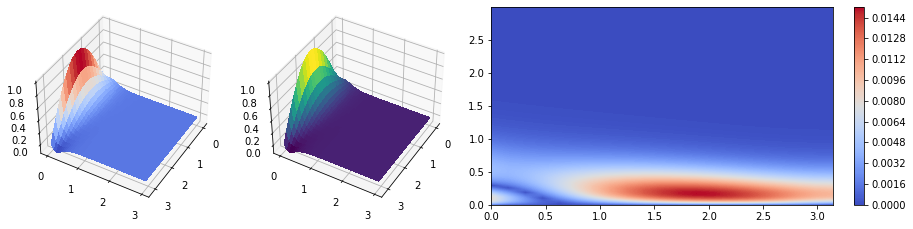

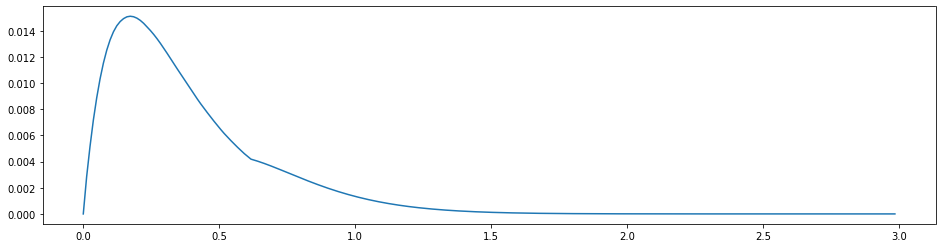

### 3Т2П

20 243


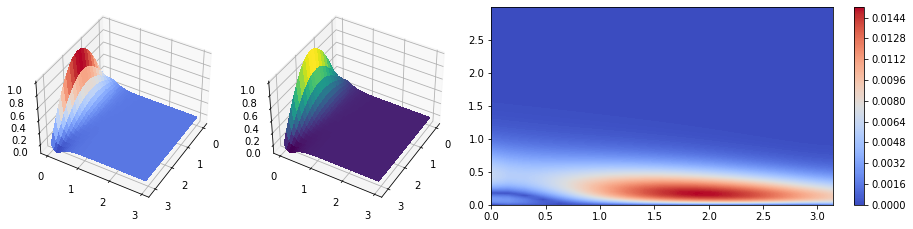

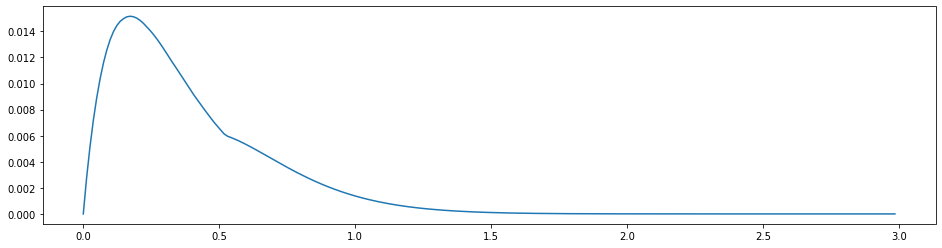

### 2Т2П

20 243


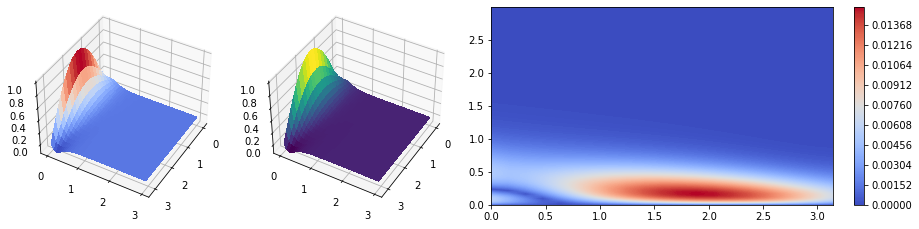

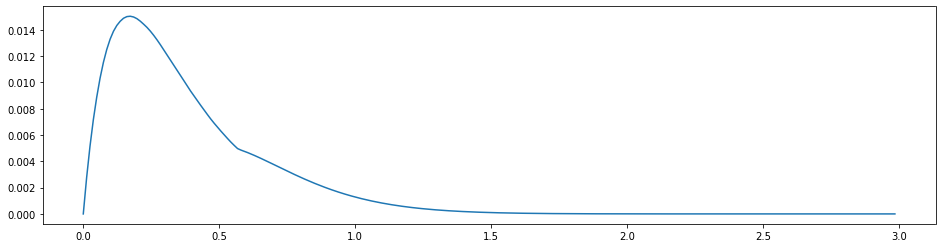

In [8]:
for i in [1,2,3]:
    display(Markdown(["### 2Т1П", "### 3Т2П", "### 2Т2П"][i-1]))
    ES = ImplicitScheme(a, b, c, l, T, sigma, n, f, psi, phi0, phil, alpha0, betta0, alphal, bettal)
    ES.solve(i)
    ES.draw3D()
    ES.delta()

#### Двусторонний метод

In [9]:
class ComplexScheme(Scheme):
    
    def __init__(self, a, b, c, l, T, sigma, n, f, psi, phi0, phil, alpha0, betta0, alphal, bettal, tetta = 1/2):
        super().__init__(a, b, c, l, T, sigma, n, f, psi, phi0, phil, alpha0, betta0, alphal, bettal)
        self.tetta = tetta
    
    def solve(self, app_mode = 1):
        
        for i in range(self.n + 1):
            self.result[i][0] = self.psi(self.x_i(i))

        aa = ((self.b * self.tau / (2 * self.h)) - (self.a * self.tau / (self.h**2))) * self.tetta
        bb = 1 + ((2*self.a*self.tau / (self.h**2)) - self.c * self.tau) * self.tetta
        gg = (- (self.a * self.tau / (self.h**2)) - (self.b * self.tau / (2 * self.h))) * self.tetta
        x = self.alpha0 / (2 * self.h * gg)
        y = - self.alphal / (2 * self.h * aa)
        
        
        abc = [[0]*self.n, [0] * (self.n + 1), [0]*self.n]
        d = [0] * (self.n + 1)
        
        for j in range(1, self.k + 1):

            if app_mode == 1:
                for i in range(self.n + 1):
                    if i == 0:
                        d[i] = self.phi0(self.t_k(j))
                    elif i == n: 
                        d[i] = self.phil(self.t_k(j))
                    else: 
                        d[i] = (aa * (self.tetta - 1) * self.result[i-1][j-1] \
                              + (bb * (self.tetta - 1) + 1) * self.result[i][j-1] \
                              + gg * (self.tetta - 1) * self.result[i+1][j-1]) / self.tetta \
                              + self.tau * (self.tetta * self.f(self.x_i(i), self.t_k(j)) \
                              + (1 - self.tetta) * self.f(self.x_i(i), self.t_k(j-1)))
                        
                    if i == 0:
                        abc[1][i] = self.betta0 - self.alpha0 / self.h
                        abc[2][i] = self.alpha0 / self.h
                    elif i == n:
                        abc[0][i-1] = - self.alphal / self.h
                        abc[1][i] = self.alphal / self.h + self.bettal
                    else:
                        abc[0][i-1] = aa
                        abc[1][i] = bb
                        abc[2][i] = gg
                        
                r = self._TMA(abc, d)
                
                for i in range(self.n + 1):
                    self.result[i][j] = r[i]
                    
            elif app_mode == 2:
                for i in range(self.n + 1):
                    if i == 0:
                        d[1] = (aa * (self.tetta - 1) * self.result[0][j-1] \
                              + (bb * (self.tetta - 1) + 1) * self.result[1][j-1] \
                              + gg * (self.tetta - 1) * self.result[2][j-1]) / self.tetta \
                              + self.tau * (self.tetta * self.f(self.x_i(1), self.t_k(j)) \
                              + (1 - self.tetta) * self.f(self.x_i(1), self.t_k(j-1)))
                        d[i] = self.phi0(self.t_k(j)) + d[1] * x
                    elif i == n: 
                        d[i] = self.phil(self.t_k(j)) + d[n-1] * y
                    else: 
                        d[i] = (aa * (self.tetta - 1) * self.result[i-1][j-1] \
                              + (bb * (self.tetta - 1) + 1) * self.result[i][j-1] \
                              + gg * (self.tetta - 1) * self.result[i+1][j-1]) / self.tetta \
                              + self.tau * (self.tetta * self.f(self.x_i(i), self.t_k(j)) \
                              + (1 - self.tetta) * self.f(self.x_i(i), self.t_k(j-1)))
                        
                    if i == 0:
                        abc[1][i] = self.betta0 - 3 * self.alpha0 / (2 * self.h) + aa * x
                        abc[2][i] = 2 * self.alpha0 / self.h + bb * x
                    elif i == n:
                        abc[0][i-1] = - 2 * self.alphal / self.h + bb * y
                        abc[1][i] = 3 * self.alphal / (2 * self.h) + self.bettal + gg * y
                    else:
                        abc[0][i-1] = aa
                        abc[1][i] = bb
                        abc[2][i] = gg
                        
                r = self._TMA(abc, d)
                
                for i in range(self.n + 1):
                    self.result[i][j] = r[i]
                    
            elif app_mode == 3:
                for i in range(self.n + 1):
                    if i == 0:
                        d[i] = (self.h - self.h**2 * self.b / (2 * self.a)) * self.phi0(self.t_k(j)) \
                               - (self.alpha0 * self.h**2 / (2 * self.a * self.tau)) * self.result[i][j-1] \
                               - (self.alpha0 * self.h**2 / (2 * self.a)) * self.f(0, self.t_k(j))
                    elif i == n: 
                        d[i] = (self.h + self.h**2 * self.b / (2 * self.a)) * self.phil(self.t_k(j)) \
                               + (self.alphal * self.h**2 / (2 * self.a * self.tau)) * self.result[i][j-1] \
                               + (self.alphal * self.h**2 / (2 * self.a)) * self.f(self.l, self.t_k(j))
                    else: 
                        d[i] = (aa * (self.tetta - 1) * self.result[i-1][j-1] \
                              + (bb * (self.tetta - 1) + 1) * self.result[i][j-1] \
                              + gg * (self.tetta - 1) * self.result[i+1][j-1]) / self.tetta \
                              + self.tau * (self.tetta * self.f(self.x_i(i), self.t_k(j)) \
                              + (1 - self.tetta) * self.f(self.x_i(i), self.t_k(j-1)))
                        
                    if i == 0:
                        abc[1][i] = self.alpha0 * (self.h**2 * self.c / (2 * self.a) - self.h**2 / (2 * self.a * self.tau) - 1)\
                                    + self.betta0 * (self.h - self.h**2 * self.b / (2 * self.a))
                        abc[2][i] = self.alpha0
                    elif i == n:
                        abc[0][i-1] = -self.alphal
                        abc[1][i] = self.alphal * (1 + self.h**2 / (2 * self.a * self.tau) - self.h**2 * self.c / (2 * self.a))\
                                    + self.bettal * (self.h + self.h**2 * self.b / (2 * self.a))
                    else:
                        abc[0][i-1] = aa
                        abc[1][i] = bb
                        abc[2][i] = gg
                        
                r = self._TMA(abc, d)
                
                for i in range(self.n + 1):
                    self.result[i][j] = r[i]
            
        return self.result

### 2Т1П

20 243


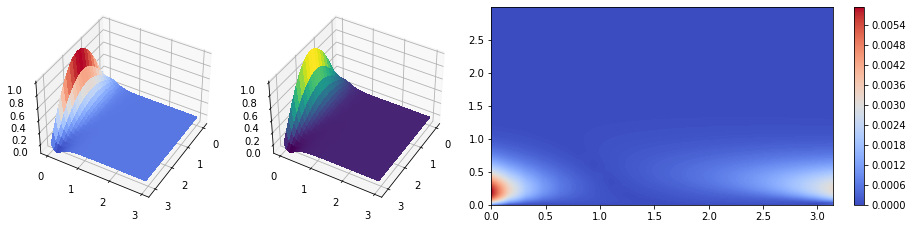

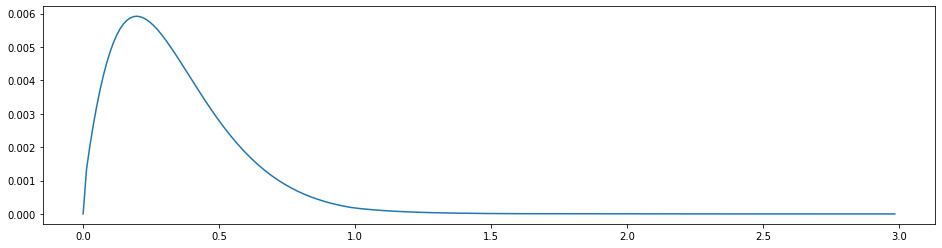

### 3Т2П

20 243


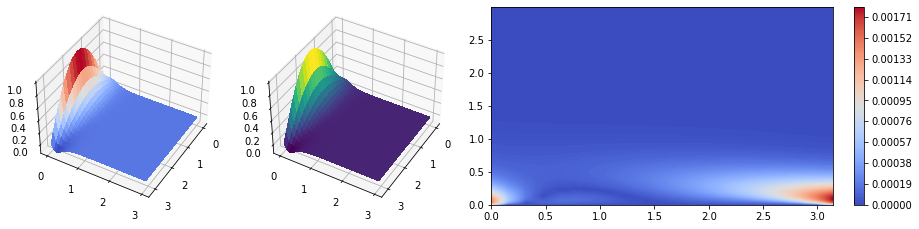

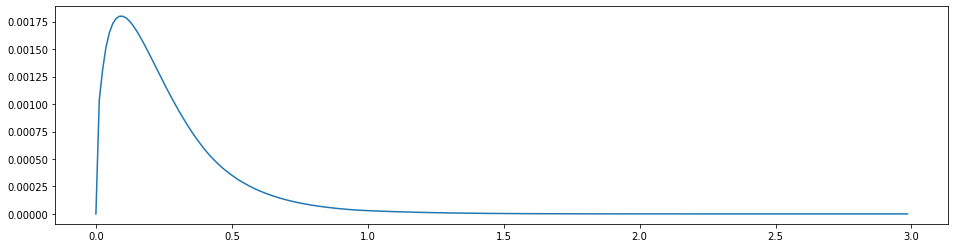

### 2Т2П

20 243


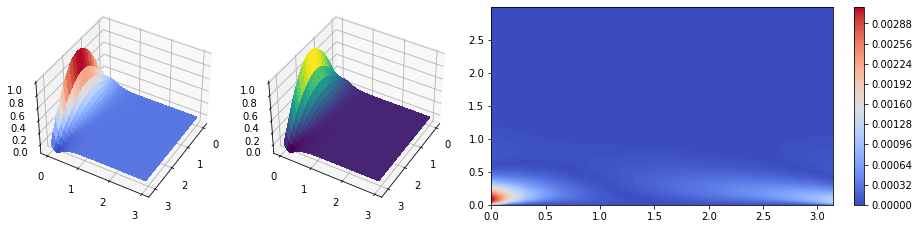

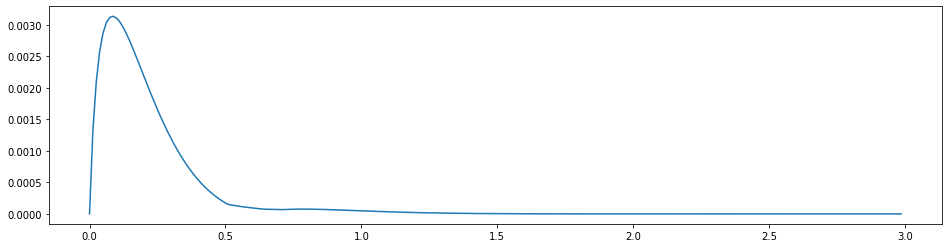

In [10]:
for i in [1,2,3]:
    display(Markdown(["### 2Т1П", "### 3Т2П", "### 2Т2П"][i-1]))
    ES = ComplexScheme(a, b, c, l, T, sigma, n, f, psi, phi0, phil, alpha0, betta0, alphal, bettal, 1/2)
    ES.solve(i)
    ES.draw3D()
    ES.delta()